In [93]:
import pandas as pd
import numpy as np

import sklearn
from sklearn.model_selection import train_test_split

# from sklean.svm import 
from sklearn.ensemble import RandomForestRegressor

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns; sns.set()

import torch
import torch.nn as nn

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

seed = 3

# Train, test MLP re: predicting lineup `diff_pts` from clusters (non-bpm and bpm weighted)



## Create X, y, and train test split partition

In [15]:
df = pd.read_csv('datasets/master_4man_lineup_clusters_2000_2020.csv', index_col=0)
# df.sort_values(by='diff_pts')

cluster_cols = [f'cluster_{n}' for n in range(12)]
X = df[cluster_cols]
# X
y = df['diff_pts']
# y.sort_values()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)


In [22]:
# y_train.sort_values()
y_test.sort_values()

lineup
M. World Peace | E. Brand | R. Brown | D. Simpkins CHI 2000             -23.4
K. Bryant | J. Clarkson | R. Hibbert | D. Russell LAL 2016              -22.5
J. Clarkson | R. Hibbert | J. Randle | L. Williams LAL 2016             -20.1
T. Hardaway | K. Knox | E. Mudiay | N. Vonleh NYK 2019                  -18.9
K. Durant | J. Green | T. Sefolosha | R. Westbrook OKC 2009             -18.3
                                                                         ... 
M. World Peace | J. Foster | R. Miller | J. Tinsley IND 2004             23.5
M. Dellavedova | L. James | K. Love | T. Thompson CLE 2016               25.4
S. Curry | D. Green | D. Lee | K. Thompson GSW 2014                      26.4
D. Gallinari | S. Gilgeous-Alexander | C. Paul | D. Schröder OKC 2020    26.7
R. Alston | C. Hayes | T. McGrady | Y. Ming HOU 2007                     27.1
Name: diff_pts, Length: 1045, dtype: float64

## Build MLP

In [39]:
def build_MLP(sizes, activation, output_activation=nn.Identity):
    layers = []
    for i in range(len(sizes)-1):
        active_fn = activation if i < len(sizes) - 2 else output_activation
        layers += [nn.Linear(in_features=sizes[i], out_features=sizes[i+1]), active_fn()]
    mlp = nn.Sequential(*layers)
    return mlp

### Train and test the 3-layer mlp

In [40]:
input_dim = [12]
hidden_sizes = [24, 24]
output_dim = [1]
sizes = input_dim + hidden_sizes + output_dim
activation = nn.ReLU

mlp = build_MLP(sizes, activation)
mlp

Sequential(
  (0): Linear(in_features=12, out_features=24, bias=True)
  (1): ReLU()
  (2): Linear(in_features=24, out_features=24, bias=True)
  (3): ReLU()
  (4): Linear(in_features=24, out_features=1, bias=True)
  (5): Identity()
)

In [66]:
# X_train_tensor = torch.tensor(X_train.to_numpy(), dtype=torch.float32)
# X_train_tensor[0]

def torch_train_test_split(X, y, test_size, random_state=3):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
    datasets = []
    for dataset in [X_train, X_test, y_train, y_test]:
        datasets.append(torch.tensor(dataset.to_numpy(), dtype=torch.float32))        
    return datasets
    

Wall time: 2min 38s


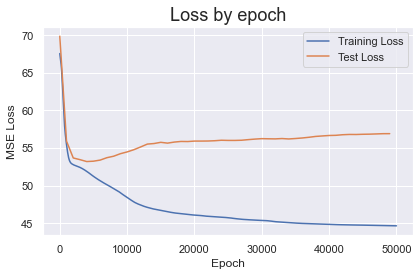

In [127]:
%%time

input_dim = [12]
hidden_sizes = [24, 24]
output_dim = [1]
sizes = input_dim + hidden_sizes + output_dim
activation = nn.ReLU

mlp = build_MLP(sizes, activation)
# mlp


mlp_learning_rate = 0.0001
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(params=mlp.parameters(), lr=mlp_learning_rate)

epochs = 50_000

X_train_tensor, X_test_tensor, y_train_tensor, y_test_tensor = torch_train_test_split(X, y, 0.2, seed)
training_losses = []
test_losses = {}
for epoch in range(epochs):
    optimizer.zero_grad()
    y_hat = mlp(X_train_tensor)
    train_loss = loss_fn(y_hat.reshape(-1), y_train_tensor)
    training_losses.append(train_loss.item())    
#         print('EPOCH:', epoch, end='   |   ')
#         print('LOSS:', loss.item())
    train_loss.backward()
    optimizer.step()
    
    if epoch%1_000==0:
        y_hat_test = mlp(X_test_tensor)
        test_loss = loss_fn(y_hat_test.reshape(-1), y_test_tensor)
        test_losses[epoch] = test_loss.item()

        
### Plot training results:
train_plot = sns.lineplot(x=[i for i in range(epochs)], y=training_losses, label='Training Loss')
plt.tight_layout()
train_plot.set_title('Loss by epoch', fontsize=18)
train_plot.set_ylabel('MSE Loss')
train_plot.set_xlabel('Epoch')

test_plot = sns.lineplot(x=test_losses.keys(), y=[test_losses[epoch] for epoch in test_losses.keys()], label='Test Loss')
plt.tight_layout()
# test_plot.set_title('', fontsize=18)
test_plot.set_ylabel('MSE Loss')
test_plot.set_xlabel('Epoch')

plt.legend();

### Train for 3k epochs

Wall time: 9.65 s


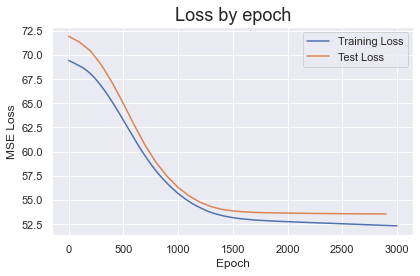

In [129]:
%%time

input_dim = [12]
hidden_sizes = [24, 24]
output_dim = [1]
sizes = input_dim + hidden_sizes + output_dim
activation = nn.ReLU
mlp = build_MLP(sizes, activation)

mlp_learning_rate = 0.0001
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(params=mlp.parameters(), lr=mlp_learning_rate)

epochs = 3000

X_train_tensor, X_test_tensor, y_train_tensor, y_test_tensor = torch_train_test_split(X, y, 0.2, seed)
training_losses = []
test_losses = {}
for epoch in range(epochs):
    optimizer.zero_grad()
    y_hat = mlp(X_train_tensor)
    train_loss = loss_fn(y_hat.reshape(-1), y_train_tensor)
    training_losses.append(train_loss.item())    
#         print('EPOCH:', epoch, end='   |   ')
#         print('LOSS:', loss.item())
    train_loss.backward()
    optimizer.step()
    
    if epoch%100==0:
        y_hat_test = mlp(X_test_tensor)
        test_loss = loss_fn(y_hat_test.reshape(-1), y_test_tensor)
        test_losses[epoch] = test_loss.item()

        
### Plot training results:
train_plot = sns.lineplot(x=[i for i in range(epochs)], y=training_losses, label='Training Loss')
plt.tight_layout()
train_plot.set_title('Loss by epoch', fontsize=18)
train_plot.set_ylabel('MSE Loss')
train_plot.set_xlabel('Epoch')

test_plot = sns.lineplot(x=test_losses.keys(), y=[test_losses[epoch] for epoch in test_losses.keys()], label='Test Loss')
plt.tight_layout()
# test_plot.set_title('', fontsize=18)
test_plot.set_ylabel('MSE Loss')
test_plot.set_xlabel('Epoch')

plt.legend();

## Test loss ~53%

## Test MLP on held out test data

In [130]:
y_hat_test = mlp(X_test_tensor)

loss = loss_fn(y_hat_test.reshape(-1), y_test_tensor)
print(loss.item())

53.530799865722656


## Test Random lineup predictions

In [163]:
lineup[cluster_cols].astype(float)

cluster_0     0.085570
cluster_1     0.000257
cluster_2     0.914418
cluster_3     0.000282
cluster_4     0.000000
cluster_5     0.000359
cluster_6     0.999455
cluster_7     1.000000
cluster_8     0.000005
cluster_9     0.000000
cluster_10    0.999653
cluster_11    0.000000
Name: B. Coles | A. Henderson | J. Jackson | D. Mutombo ATL 2000, dtype: float64

In [170]:
for i in range(5,len(df),500):
    lineup = df.iloc[i]
    print(lineup.name)
    print('Point differential:', lineup['diff_pts'])
    lineup_cluster_tensor = lineup[cluster_cols].astype(float).to_numpy()
    lineup_cluster_tensor = torch.tensor(lineup_cluster_tensor, dtype=torch.float32)
    y_hat = mlp(lineup_cluster_tensor).item()
    print('Predicted point differential:', y_hat)
    print('\n')

A. Henderson | J. Jackson | D. Mutombo | J. Terry ATL 2000
Point differential: -11.3
Predicted point differential: -0.34854811429977417


K. Irving | M. Morris | M. Smart | J. Tatum BOS 2019
Point differential: 7.4
Predicted point differential: 1.3168466091156006


H. Eisley | M. Finley | S. Nash | D. Nowitzki DAL 2001
Point differential: 11.3
Predicted point differential: 5.824050426483154


M. Blaylock | J. Caffey | A. Foyle | L. Hughes GSW 2000
Point differential: -17.3
Predicted point differential: -2.838157892227173


L. Allen | P. George | G. Hill | I. Mahinmi IND 2016
Point differential: 4.4
Predicted point differential: 1.3042705059051514


S. Battier | P. Gasol | G. Giriček | J. Williams MEM 2003
Point differential: -8.3
Predicted point differential: 3.3791885375976562


K. Garnett | T. Hudson | A. Peeler | W. Szczerbiak MIN 2003
Point differential: 8.7
Predicted point differential: 4.317018508911133


N. Collison | K. Durant | E. Watson | C. Wilcox SEA 2008
Point differential

## With BPM wieghted data

Wall time: 15.2 s


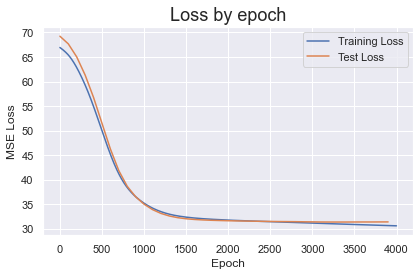

In [272]:
%%time

input_dim = [12]
hidden_sizes = [24, 24]
output_dim = [1]
sizes = input_dim + hidden_sizes + output_dim
activation = nn.ReLU
mlp = build_MLP(sizes, activation)

mlp_learning_rate = 0.0001
loss_fn = nn.MSELoss()
# loss_fn = nn.L1Loss()
optimizer = torch.optim.Adam(params=mlp.parameters(), lr=mlp_learning_rate)

epochs = 4000

## Get the bpm clusters as X data
df = pd.read_csv('datasets/master_4man_lineup_clusters_2000_2020.csv', index_col=0)
bpm_cluster_cols = [f'cluster_{n}_bpm' for n in range(12)]
X_bpm = df[bpm_cluster_cols]

X_train_tensor, X_test_tensor, y_train_tensor, y_test_tensor = torch_train_test_split(X_bpm, y, 0.2, seed)



training_losses = []
test_losses = {}
for epoch in range(epochs):
    optimizer.zero_grad()
    y_hat = mlp(X_train_tensor)
    train_loss = loss_fn(y_hat.reshape(-1), y_train_tensor)
    training_losses.append(train_loss.item())    
#         print('EPOCH:', epoch, end='   |   ')
#         print('LOSS:', loss.item())
    train_loss.backward()
    optimizer.step()
    
    if epoch%100==0:
        y_hat_test = mlp(X_test_tensor)
        test_loss = loss_fn(y_hat_test.reshape(-1), y_test_tensor)
        test_losses[epoch] = test_loss.item()

        
### Plot training results:
train_plot = sns.lineplot(x=[i for i in range(epochs)], y=training_losses, label='Training Loss')
plt.tight_layout()
train_plot.set_title('Loss by epoch', fontsize=18)
train_plot.set_ylabel('MSE Loss')
train_plot.set_xlabel('Epoch')

test_plot = sns.lineplot(x=test_losses.keys(), y=[test_losses[epoch] for epoch in test_losses.keys()], label='Test Loss')
plt.tight_layout()
# test_plot.set_title('', fontsize=18)
test_plot.set_ylabel('MSE Loss')
test_plot.set_xlabel('Epoch')

plt.legend();

## Test random sample predictions

In [226]:
for i in range(6,len(df),500):
    lineup = df.iloc[i]
    print(lineup.name)
    print('Point differential:', lineup['diff_pts'])
    lineup_cluster_tensor = lineup[cluster_cols].astype(float).to_numpy()
    lineup_cluster_tensor = torch.tensor(lineup_cluster_tensor, dtype=torch.float32)
    y_hat = mlp(lineup_cluster_tensor).item()
    print('Predicted point differential:', y_hat)
    mse_loss = (lineup['diff_pts'] - y_hat)**2
    abs_loss = np.abs((lineup['diff_pts'] - y_hat))
    
    print('MSE Loss:', mse_loss)
    print('ABS Loss:', abs_loss)
    
    print('\n')

A. Henderson | J. Jackson | R. McLeod | D. Mutombo ATL 2000
Point differential: -14.8
Predicted point differential: 3.3851912021636963
MSE Loss: 330.7011790592519
ABS Loss: 18.185191202163697


A. Horford | K. Irving | M. Morris | M. Smart BOS 2019
Point differential: 6.1
Predicted point differential: 4.496297359466553
MSE Loss: 2.57186215925395
ABS Loss: 1.603702640533447


S. Bradley | H. Eisley | M. Finley | D. Nowitzki DAL 2001
Point differential: 15.9
Predicted point differential: 4.0391364097595215
MSE Loss: 140.68008510629227
ABS Loss: 11.860863590240479


M. Blaylock | M. Jackson | A. Jamison | B. Sura GSW 2001
Point differential: -9.6
Predicted point differential: 4.239412784576416
MSE Loss: 191.52934622189713
ABS Loss: 13.839412784576416


L. Allen | M. Ellis | G. Hill | I. Mahinmi IND 2016
Point differential: 8.5
Predicted point differential: 3.6677634716033936
MSE Loss: 23.350509866370487
ABS Loss: 4.8322365283966064


P. Gasol | G. Giriček | J. Williams | L. Wright MEM 200

## Try a much bigger MLP

Wall time: 2min 13s


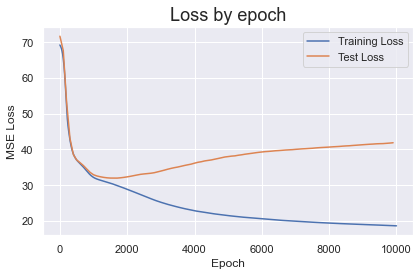

In [271]:
%%time

input_dim = [12]
hidden_sizes = [24, 72, 72, 24]
output_dim = [1]
sizes = input_dim + hidden_sizes + output_dim
activation = nn.ReLU
mlp = build_MLP(sizes, activation)

mlp_learning_rate = 0.0001
loss_fn = nn.MSELoss()
# loss_fn = nn.L1Loss()
optimizer = torch.optim.Adam(params=mlp.parameters(), lr=mlp_learning_rate)

epochs = 10000

## Get the bpm clusters as X data
df = pd.read_csv('datasets/master_4man_lineup_clusters_2000_2020.csv', index_col=0)
bpm_cluster_cols = [f'cluster_{n}_bpm' for n in range(12)]
X_bpm = df[bpm_cluster_cols]
X_train_tensor, X_test_tensor, y_train_tensor, y_test_tensor = torch_train_test_split(X_bpm, y, 0.2, seed)

training_losses = []
test_losses = {}
for epoch in range(epochs):
    optimizer.zero_grad()
    y_hat = mlp(X_train_tensor)
    train_loss = loss_fn(y_hat.reshape(-1), y_train_tensor)
    training_losses.append(train_loss.item())    
#         print('EPOCH:', epoch, end='   |   ')
#         print('LOSS:', loss.item())
    train_loss.backward()
    optimizer.step()
    
    if epoch%100==0:
        y_hat_test = mlp(X_test_tensor)
        test_loss = loss_fn(y_hat_test.reshape(-1), y_test_tensor)
        test_losses[epoch] = test_loss.item()

        
### Plot training results:
train_plot = sns.lineplot(x=[i for i in range(epochs)], y=training_losses, label='Training Loss')
plt.tight_layout()
train_plot.set_title('Loss by epoch', fontsize=18)
train_plot.set_ylabel('MSE Loss')
train_plot.set_xlabel('Epoch')

test_plot = sns.lineplot(x=test_losses.keys(), y=[test_losses[epoch] for epoch in test_losses.keys()], label='Test Loss')
plt.tight_layout()
# test_plot.set_title('', fontsize=18)
test_plot.set_ylabel('MSE Loss')
test_plot.set_xlabel('Epoch')

plt.legend();

## Trying even bigger MLP

Wall time: 2min 20s


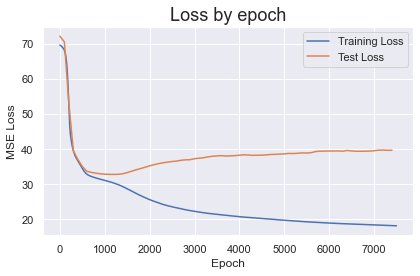

In [273]:
%%time

input_dim = [12]
hidden_sizes = [24, 72, 72, 72, 24, 12]
output_dim = [1]
sizes = input_dim + hidden_sizes + output_dim
activation = nn.ReLU
mlp = build_MLP(sizes, activation)

mlp_learning_rate = 0.0001
loss_fn = nn.MSELoss()
# loss_fn = nn.L1Loss()
optimizer = torch.optim.Adam(params=mlp.parameters(), lr=mlp_learning_rate)

epochs = 7500

## Get the bpm clusters as X data
df = pd.read_csv('datasets/master_4man_lineup_clusters_2000_2020.csv', index_col=0)
bpm_cluster_cols = [f'cluster_{n}_bpm' for n in range(12)]
X_bpm = df[bpm_cluster_cols]
X_train_tensor, X_test_tensor, y_train_tensor, y_test_tensor = torch_train_test_split(X_bpm, y, 0.2, seed)

training_losses = []
test_losses = {}
for epoch in range(epochs):
    optimizer.zero_grad()
    y_hat = mlp(X_train_tensor)
    train_loss = loss_fn(y_hat.reshape(-1), y_train_tensor)
    training_losses.append(train_loss.item())    
#         print('EPOCH:', epoch, end='   |   ')
#         print('LOSS:', loss.item())
    train_loss.backward()
    optimizer.step()
    
    if epoch%100==0:
        y_hat_test = mlp(X_test_tensor)
        test_loss = loss_fn(y_hat_test.reshape(-1), y_test_tensor)
        test_losses[epoch] = test_loss.item()

        
### Plot training results:
train_plot = sns.lineplot(x=[i for i in range(epochs)], y=training_losses, label='Training Loss')
plt.tight_layout()
train_plot.set_title('Loss by epoch', fontsize=18)
train_plot.set_ylabel('MSE Loss')
train_plot.set_xlabel('Epoch')

test_plot = sns.lineplot(x=test_losses.keys(), y=[test_losses[epoch] for epoch in test_losses.keys()], label='Test Loss')
plt.tight_layout()
test_plot.set_ylabel('MSE Loss')
test_plot.set_xlabel('Epoch')

plt.legend();

## RandomForestRegressor

In [265]:
from sklearn.model_selection import cross_val_score
rfr = RandomForestRegressor()

# scorer = sklearn.metrics.make_scorer()
scores = cross_val_score(rfr, X, y, cv=10, scoring="neg_mean_squared_error")
scores.mean()

-55.107405776532076

In [264]:
sorted(sklearn.metrics.SCORERS.keys())
## "neg mse" since sklearn losses are all greater is better

['accuracy',
 'adjusted_mutual_info_score',
 'adjusted_rand_score',
 'average_precision',
 'balanced_accuracy',
 'completeness_score',
 'explained_variance',
 'f1',
 'f1_macro',
 'f1_micro',
 'f1_samples',
 'f1_weighted',
 'fowlkes_mallows_score',
 'homogeneity_score',
 'jaccard',
 'jaccard_macro',
 'jaccard_micro',
 'jaccard_samples',
 'jaccard_weighted',
 'max_error',
 'mutual_info_score',
 'neg_brier_score',
 'neg_log_loss',
 'neg_mean_absolute_error',
 'neg_mean_gamma_deviance',
 'neg_mean_poisson_deviance',
 'neg_mean_squared_error',
 'neg_mean_squared_log_error',
 'neg_median_absolute_error',
 'neg_root_mean_squared_error',
 'normalized_mutual_info_score',
 'precision',
 'precision_macro',
 'precision_micro',
 'precision_samples',
 'precision_weighted',
 'r2',
 'recall',
 'recall_macro',
 'recall_micro',
 'recall_samples',
 'recall_weighted',
 'roc_auc',
 'roc_auc_ovo',
 'roc_auc_ovo_weighted',
 'roc_auc_ovr',
 'roc_auc_ovr_weighted',
 'v_measure_score']

## Try RFR with BPM clusters

In [268]:
rfr = RandomForestRegressor()

# scorer = sklearn.metrics.make_scorer()
scores = cross_val_score(rfr, X_bpm, y, cv=10, scoring="neg_mean_squared_error")
scores.mean()

## Much better results

-37.96515311324285

In [321]:
X_train_bpm, X_test_bpm, y_train_bpm, y_test_bpm = train_test_split(X_bpm, y, test_size=.2, random_state=seed)
rfr.fit(X_train_bpm, y_train_bpm)

RandomForestRegressor()

## Comapre MLP, RFR, and actual pts diff

In [335]:
rfr_pred = rfr.predict(X_test_bpm)

X_test_bpm_tensor = torch.tensor(X_test_bpm.to_numpy(), dtype=torch.float32)
mlp_pred = mlp(X_test_bpm_tensor).detach().numpy()

# X_test_bpm

df = pd.DataFrame(rfr_pred, index=X_test_bpm.index, columns=['rfr_pred'])
df['mlp_prd'] = mlp_pred
df['diff_pts'] = y_test_bpm
df.sample(25)

,rfr_pred,mlp_prd,diff_pts
lineup,,,
B. Barry | J. James | R. Lewis | G. Payton SEA 2002,-0.060,0.464145,14.8
K. Brown | K. Bryant | L. Odom | S. Parker LAL 2006,7.036,4.195578,3.7
C. Anthony | G. Buckner | F. Elson | A. Miller DEN 2006,3.143,2.038587,10.6
M. Beasley | W. Johnson | K. Love | D. Miličić MIN 2011,-4.448,1.882074,-3.6
A. Afflalo | C. Anthony | C. Billups | N. Hilário DEN 2010,5.448,4.723421,4.8
N. Batum | D. Lillard | R. Lopez | M. Williams POR 2014,4.860,-2.707633,14.6
R. Allen | K. Garnett | P. Pierce | R. Rondo BOS 2009,10.995,7.824108,14.1
S. Hawes | J. Holiday | E. Turner | N. Young PHI 2013,-3.960,-9.749916,-10.5
K. Faried | R. Foye | T. Lawson | T. Mozgov DEN 2014,2.575,-0.543704,4.5


In [304]:
y_hat = mlp(X_test_tensor).detach()

In [305]:
y_hat = np.array(y_hat)

In [307]:
df = pd.DataFrame(y_hat, index=X_test.index, columns=['rfr_pred'])
df['diff_pts'] = y_test
df.head()

,rfr_pred,diff_pts
lineup,,
L. Aldridge | D. Cunningham | W. Matthews | A. Miller POR 2011,-3.177582,-0.6
P. Brown | J. Magloire | J. Mashburn | D. Wesley CHH 2001,-2.276646,3.7
D. Coleman | M. Harpring | A. Iverson | D. Mutombo PHI 2002,6.201124,6.7
A. Houston | M. Jackson | L. Sprewell | K. Thomas NYK 2002,-3.590418,-10.2
L. Galloway | J. Grant | L. Thomas | D. Williams NYK 2016,-8.900270,-8.2


In [311]:
# df.sort_values(by='rfr_pred')
df.sample(25)

,rfr_pred,diff_pts
lineup,,
J. Crawford | R. Felton | A. Rivers | M. Speights LAC 2017,-4.865489,-5.4
K. Garnett | T. Hudson | L. Sprewell | W. Szczerbiak MIN 2005,5.629541,-6.2
M. World Peace | A. Bynum | P. Gasol | R. Sessions LAL 2012,2.271178,9.0
M. Barnes | E. Bledsoe | L. Odom | R. Turiaf LAC 2013,3.918600,10.0
T. Ariza | S. Battier | A. Brooks | C. Landry HOU 2010,4.876837,-3.4
L. Deng | K. Korver | J. Noah | D. Rose CHI 2011,9.526697,12.1
K. Anderson | A. Griffin | P. Pierce | V. Potapenko BOS 2000,0.095221,1.5
J. Harden | B. McLemore | P. Tucker | R. Westbrook HOU 2020,5.811133,18.1
D. Anderson | D. Davis | R. Patterson | R. Wallace POR 2002,12.096731,10.1
